# Case Study Unit 6 - Real-Time Location System

Yao Yao, Brian Kruse, Ivelin Angelov

MSDS 7333 Section 402

June 18, 2018

## Introduction

Real-time location system (RTLS) for WiFi signals are used to predict the location of a device, where location prediction is achieved by application of the k-nearest neighbors (kNN) clustering technique to a real location data set. Both weighted and unweighted kNN are used and performance of the two classification methods on the data is then evaluated and compared against simple average predictions to determine the best prediction method. While prediction estimates for both models appear fairly close, we find the weighted kNN distance methodology to have the best method for location prediction. 

While GPS has become a ubiquitous solution for outdoor real-time locating, RTLS technology has evolved and become much more prevalent for indoor tracking. The RTLS data set used is comprised of MAC addresses from recorded connections made to routers within the college dormitory. WiFi signal strength is measured at every router (network access point) via a mobile scanning device, and by measuring signal strength for these routers at various locations we are able to create a reference dataset on which to base device position predictions.

Advanced clustering methods are then performed on the reference dataset through the application of weighted and unweighted kNN algorithms to predict device locations. This is accomplished by leveraging the kNN clustering technique to a set of signal strengths in which we average the known (x,y) values for these neighbors to predict location estimates of devices [1]. Alternatively, a weighted average is calculated and considered as a potentially better predictor. The weights are inversely proportional to the neighbors' distance (measured in Received Signal Strength Indication, or RSSI) from the test observation, allowing inclusion of the k points that are nearest while differentiating between them by how close they actually are [1]. After implementing the alternative approach of the weighted average kNN, resulting predictions are analyzed and compared against the simple, average predictions to ultimately determine the optimal prediction method. 

## Methods

The steps used for this analysis were: data cleansing, exploratory analysis, signal strength analysis, implementation of kNN average weighting approach, implementation of kNN distance weighting approach, and comparison of kNN approaches to determine the best location prediction method.

The code used includes modified versions examples found in Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving, Chapter 1, pages 3-40 as well as from a R notebook from class [1][2].

### Data Import

For this case study we will use a dataset created by the University of Mannheim [1]. This "offline" dataset will be used as the training dataset to build our prediction model. The dataset contains 146,080 data points and each data point consists of the following fields:

t = timestamp for each data point
id = MAC address of the device conducting the scan
pos = coordinates of the device conducting the scan
degree = orientation of the device conducting the scan
MACofResponse1 = MAC address of the first responding device
MACofResponseN = MAC address of the Nth responding device

Multiple devices can respond to the scanning device (MACofResponse1 to MACofResponseN) and each of the responding devices provide the following data:
  - SignalStrength (Decibel-milliwatts dBm)
  - Frequency
  - Mode (access point=3, adhoc mode=1)
  
The code below reads in the "offline" dataset and outputs some simple observations about how many lines in the file are data versus comments.

In [1]:
# Configure number format to two decimal places only
library(formattable)
library(lattice)
library(fields)
seed = 111

# Import offline data and explore data
txt = readLines("Data/offline.final.trace.txt")

paste("Total number of lines in offline data =",length(txt))
paste("Total number of comments in offline data =", sum(substr(txt, 1, 1) == "#")) #Check number of comment lines in offline data
paste("Total number of non-comment lines =", length(txt) - sum(substr(txt, 1, 1) == "#"))

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.1-4 (2018-04-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


[1] "Total number of lines in offline data = 151392"

[1] "Total number of comments in offline data = 5312"

[1] "Total number of non-comment lines = 146080"

In [2]:
sum(substr(txt, 1, 1) == "#")
length(txt)
strsplit(txt[4], ";")[[1]]
tokens = strsplit(txt[4], "[;=,]")[[1]]
tokens[1:10]
tokens[c(2, 4, 6:8, 10)]
tokens[ - ( 1:10 ) ]

tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
mat = cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
                   ncol = 6, byrow = TRUE), 
            tmp)

dim(mat)
processLine = function(x) {
  tokens = strsplit(x, "[;=,]")[[1]]
  tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
               ncol = 6, byrow = TRUE), tmp)}

[1] 5312

[1] 151392

[1] "t=1139643118358"                    "id=00:02:2D:21:0F:33"              
 [3] "pos=0.0,0.0,0.0"                    "degree=0.0"                        
 [5] "00:14:bf:b1:97:8a=-38,2437000000,3" "00:14:bf:b1:97:90=-56,2427000000,3"
 [7] "00:0f:a3:39:e1:c0=-53,2462000000,3" "00:14:bf:b1:97:8d=-65,2442000000,3"
 [9] "00:14:bf:b1:97:81=-65,2422000000,3" "00:14:bf:3b:c7:c6=-66,2432000000,3"
[11] "00:0f:a3:39:dd:cd=-75,2412000000,3" "00:0f:a3:39:e0:4b=-78,2462000000,3"
[13] "00:0f:a3:39:e2:10=-87,2437000000,3" "02:64:fb:68:52:e6=-88,2447000000,1"
[15] "02:00:42:55:31:00=-84,2457000000,1"

[1] "t"                 "1139643118358"     "id"               
 [4] "00:02:2D:21:0F:33" "pos"               "0.0"              
 [7] "0.0"               "0.0"               "degree"           
[10] "0.0"

[1] "1139643118358"     "00:02:2D:21:0F:33" "0.0"              
[4] "0.0"               "0.0"               "0.0"

[1] "00:14:bf:b1:97:8a" "-38"               "2437000000"       
 [4] "3"                 "00:14:bf:b1:97:90" "-56"              
 [7] "2427000000"        "3"                 "00:0f:a3:39:e1:c0"
[10] "-53"               "2462000000"        "3"                
[13] "00:14:bf:b1:97:8d" "-65"               "2442000000"       
[16] "3"                 "00:14:bf:b1:97:81" "-65"              
[19] "2422000000"        "3"                 "00:14:bf:3b:c7:c6"
[22] "-66"               "2432000000"        "3"                
[25] "00:0f:a3:39:dd:cd" "-75"               "2412000000"       
[28] "3"                 "00:0f:a3:39:e0:4b" "-78"              
[31] "2462000000"        "3"                 "00:0f:a3:39:e2:10"
[34] "-87"               "2437000000"        "3"                
[37] "02:64:fb:68:52:e6" "-88"               "2447000000"       
[40] "1"                 "02:00:42:55:31:00" "-84"              
[43] "2457000000"        "1"

[1] 11 10

### Adding Structure to the Data

The code below creates a function that allows us to iteratively create matrices for each line in the "offline" dataset and merge into a data frame we can begin to organize for analysis. All comments have been removed and the dataset is now represented as a data frame instead of raw text. The data frame is now 1,181,628 rows and 10 columns.

In [3]:
tmp = lapply(txt[4:20], processLine)

sapply(tmp, nrow)

offline = as.data.frame(do.call("rbind", tmp))
dim(offline)

lines = txt[ substr(txt, 1, 1) != "#" ]
tmp = lapply(lines, processLine)
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
 
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
}

options(error = recover, warn = 1)
tmp = lapply(lines, processLine)
offline = as.data.frame(do.call("rbind", tmp), 
                        stringsAsFactors = FALSE)

[1] 11 10 10 11  9 10  9  9 10 11 11  9  9  9  8 10 14

[1] 170  10

Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"

### Cleaning the Data and Building a Representation for Analysis

We remove unwanted/unnecessary rows, provide identifiable names to the variables, and convert the variable values to their proper type. At this point all the variables are represented as strings and our data clearly has several numerical values.

The code below provides a name for each of the 10 columns in the data frame and converts the time, position, and signal variables to numeric types. This is key for comparison and correlation of these variables. Since ad-hoc devices will not be used further, any rows with ad-hoc data are removed from the data frame. This also allows us to drop the type row since we now know all the types are access points. The output below demonstrates the data cleanup and variable conversions discussed. The result is 978,443 rows and 9 columns in our "offline" data frame.

In [4]:
dim(offline)

names(offline) = c("time", "scanMac", "posX", "posY", "posZ", 
                   "orientation", "mac", "signal", 
                   "channel", "type")

numVars = c("time", "posX", "posY", "posZ", 
            "orientation", "signal")
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

offline = offline[ offline$type == "3", ]
offline = offline[ , "type" != names(offline) ]
dim(offline)

offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

unlist(lapply(offline, class))

[1] 1181628      10

[1] 978443      9

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

### Exploratory Analysis - Orientation

There are 203 unique values in the orientation column, although we were expecting only 8, based on 45 degree increments [Figure 2]. Figure 1 shows that while the values are not strictly in 45 degree increments, they are close to one of the expected values as shown in the box plot figure below. This means that while they are not exact, they are close to a target orientation value. The code below takes the orientation value from each row and assigns it to the closest expected orientation value [Figure 3].

In [5]:
summary(offline[, numVars])

summary(sapply(offline[ , c("mac", "channel", "scanMac")],
                as.factor))

offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]

length(unique(offline$orientation))

      time                          posX            posY             posZ  
 Min.   :2006-02-11 01:31:58   Min.   : 0.00   Min.   : 0.000   Min.   :0  
 1st Qu.:2006-02-11 07:21:27   1st Qu.: 2.00   1st Qu.: 3.000   1st Qu.:0  
 Median :2006-02-11 13:57:58   Median :12.00   Median : 6.000   Median :0  
 Mean   :2006-02-16 08:57:37   Mean   :13.52   Mean   : 5.897   Mean   :0  
 3rd Qu.:2006-02-19 08:52:40   3rd Qu.:23.00   3rd Qu.: 8.000   3rd Qu.:0  
 Max.   :2006-03-09 14:41:10   Max.   :33.00   Max.   :13.000   Max.   :0  
  orientation        signal     
 Min.   :  0.0   Min.   :-99.0  
 1st Qu.: 90.0   1st Qu.:-69.0  
 Median :180.0   Median :-60.0  
 Mean   :167.2   Mean   :-61.7  
 3rd Qu.:270.0   3rd Qu.:-53.0  
 Max.   :359.9   Max.   :-25.0  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

[1] 203

null device 
          1

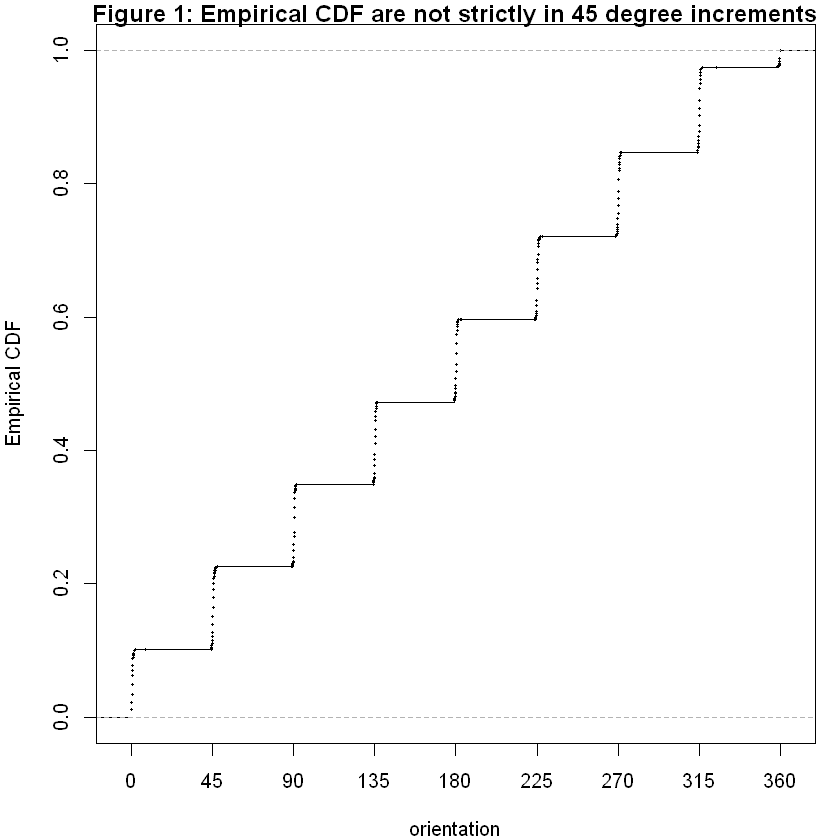

In [6]:
#plot(ecdf(offline$orientation), main = "Empirical CDF")

#pdf(file = "Geo_ECDFOrientation.pdf", width = 10, height = 7)
oldPar = par(mar = c(4, 4, 1, 1))
plot(ecdf(offline$orientation), pch = 19, cex = 0.3,
     xlim = c(-5, 365), axes = FALSE,
     xlab = "orientation", ylab = "Empirical CDF", main = "Figure 1: Empirical CDF are not strictly in 45 degree increments")
box()
axis(2)
axis(side = 1, at = seq(0, 360, by = 45))
par(oldPar)
dev.off()

null device 
          1

null device 
          1

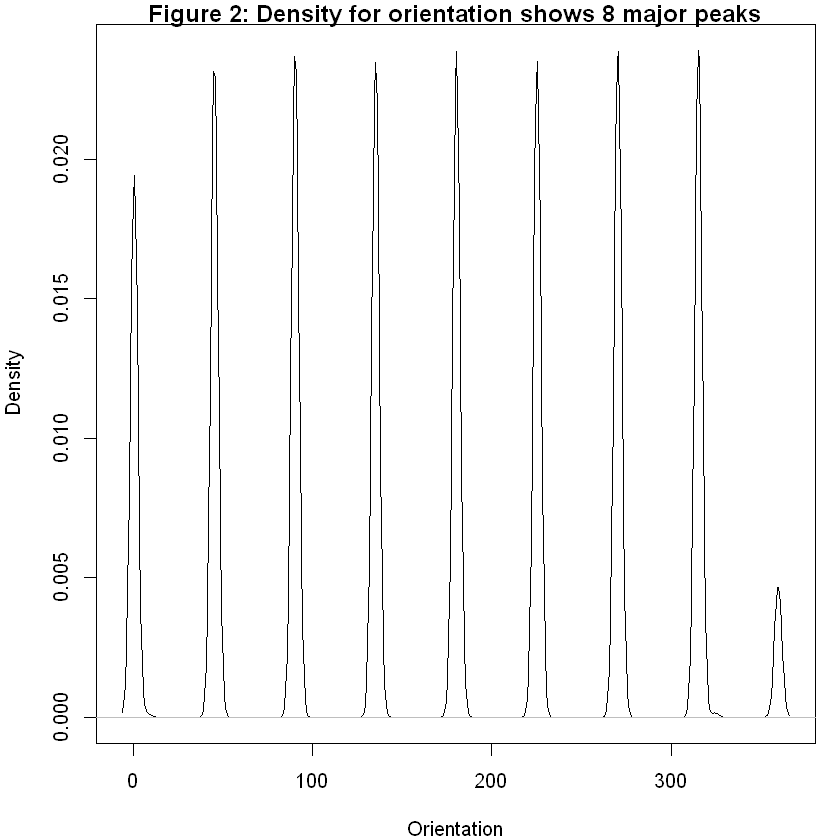

In [7]:
#pdf(file = "Geo_DensityOrientation.pdf", width = 10, height = 5)
oldPar = par(mar = c(4, 4, 1, 1))
plot(density(offline$orientation, bw = 2), 
 xlab = "Orientation", main = "")
title("Figure 2: Density for orientation shows 8 major peaks")

par(oldPar)
dev.off()

roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

offline$angle = roundOrientation(offline$orientation)

#pdf(file = "Geo_BoxplotAngle.pdf", width = 10)
oldPar = par(mar = c(4, 4, 1, 1))

par(oldPar)
dev.off()

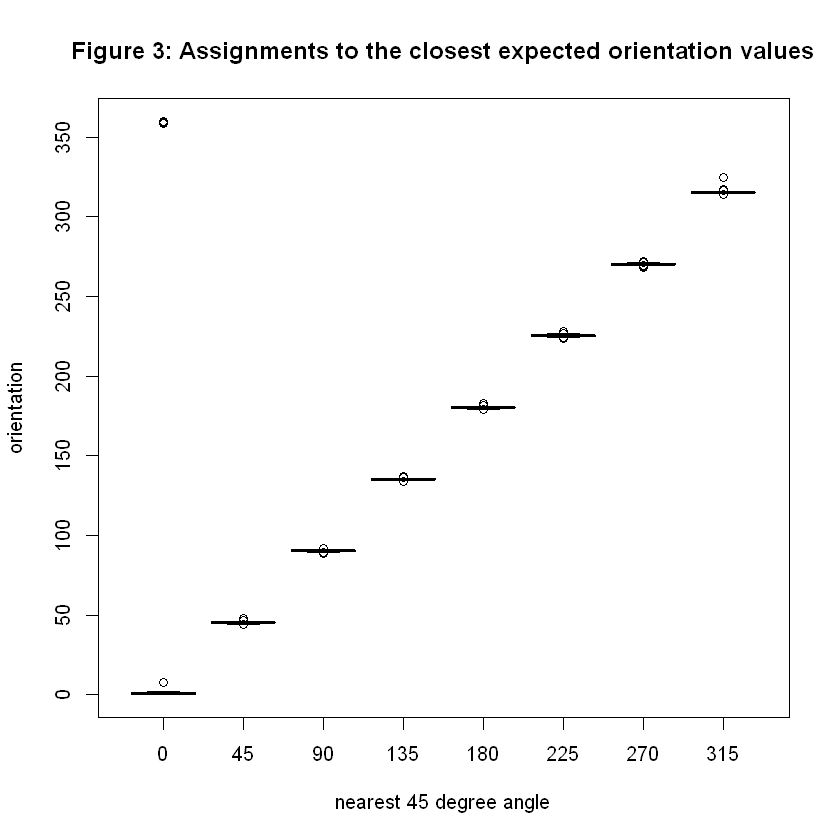

In [8]:
with(offline, boxplot(orientation ~ angle,
    xlab = "nearest 45 degree angle",
    ylab="orientation"))
title("Figure 3: Assignments to the closest expected orientation values")
par(oldPar)

### Exploratory Analysis - MAC Addresses

There are 12 MAC addresses in the dataset while the experiment design only called for and discussed 6 MAC addresses on the network. The code below shows each MAC address and the number corresponding records. There is a large variance between MAC addresses with a high number of records versus MAC addresses with a low number of records. The top 7 MAC addresses were kept in the dataset and the rest were removed.

The unique identifier for the MAC address corresponds with the identifier for channel, meaning that two values are essentially the same in our analysis and only one is necessary. No statistical significance will be gained by keeping both, which could lead to unwanted correlation between variables.

In [9]:
c(length(unique(offline$mac)), length(unique(offline$channel)))

table(offline$mac)

subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline = offline[ offline$mac %in% subMacs, ]

macChannel = with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

offline = offline[ , "channel" != names(offline)]
locDF = with(offline, 
             by(offline, list(posX, posY), function(x) x))
len.locDF = length(locDF)
len.locDF

sum.locDF.null = sum(sapply(locDF, is.null))
sum.locDF.null

[1] 12  8


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

[1] 476

[1] 310

### Exploratory Analysis - Hand-Held Device Position

The position variable is where the device was located within the experiment at the time of the data point [Figure 4]. Each position variable recorded actually contains an X and Y value. The total possible number of combinations for X and Y is 476, where 310 of values are null and 166 values are non-null. Knowing there are 166 positions where data was recorded, we can calculate the number of data points collected at each position. The matrix below shows the exact counts. While the number of data points per position are not equal, they are relatively close (~5,500), which means that our data should not be biased by the position variable.

In [10]:
locDF = locDF[ !sapply(locDF, is.null) ]
len.locDF.nonull = length(locDF)
len.locDF.nonull
locCounts = sapply(locDF, nrow)
locCounts = sapply(locDF, 
                   function(df) 
                     c(df[1, c("posX", "posY")], count = nrow(df)))

class(locCounts)
dim(locCounts)
locCounts[ , 1:8]

#pdf(file = "Geo_XYByCount.pdf", width = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))

locCounts = t(locCounts)
                       

[1] 166

[1] "matrix"

[1]   3 166

posX,0,1,2,0,1,2,0,1
posY,0,0,0,1,1,1,2,2
count,5505,5505,5506,5524,5543,5558,5503,5564


null device 
          1

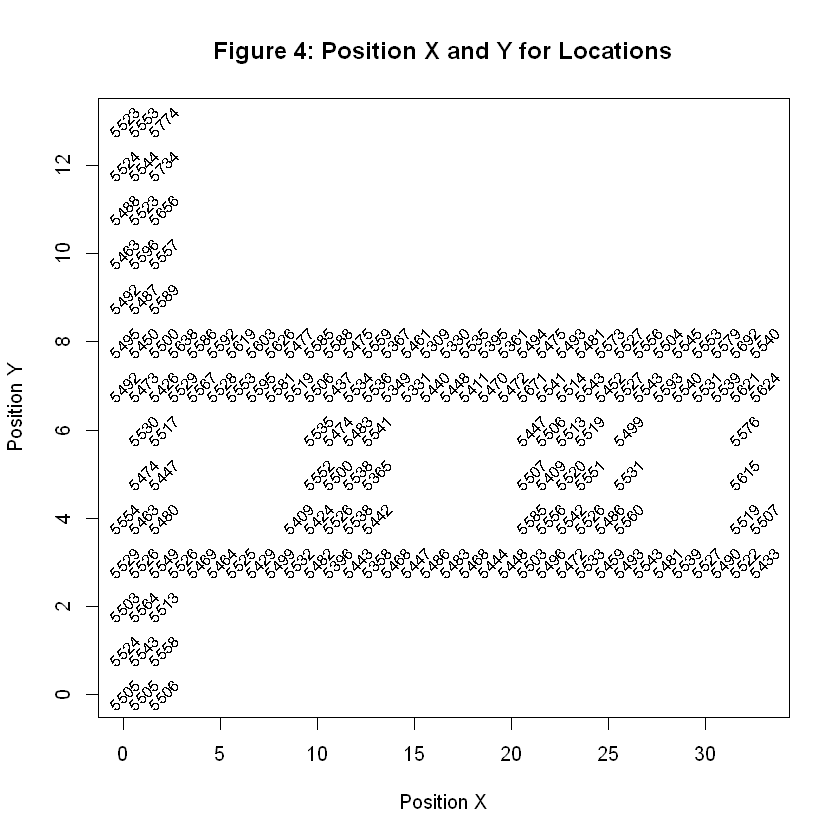

In [11]:
plot(locCounts, type = "n", xlab = "Position X", ylab = "Position Y", main = "Figure 4: Position X and Y for Locations")
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)

par(oldPar)
dev.off()

### Cleanup

The readData function will allow us to download the same data and replicate the process shown above in the order of "Data Import", "Data Cleanup", "Cleaning the Data and Building a Representation for Analysis", "EDA - Orientation", "EDA - MAC Addresses", and "EDA - Hand-Held Device Position" efficiently. The dataset for offline and offlineRedo are the same, but this function is easier to update and deploy.

In [12]:
readData = 
  function(filename = 'Data/offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

offlineRedo = readData()
identical(offline, offlineRedo)

[1] TRUE

## Results

### Signal Strength Analysis - Distribution of Signal Strength

The variable we want to understand is if the signal strength is consistent across distances and if it is significantly impacted by the other variables. The boxplot below shows the variance of the signal strength with multiple combinations of position and orientation [Figure 5]. We also output a density plot to observe the variance of these combinations, where there is a mixture of normal and skewed distributions [Figure 6]. Figure 7 shows that strong signals have a higher variance while weaker signals have a lower variance. Figure 8 shows an density graph using a summary of position, orientation, and access point combinations.

null device 
          1

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -98.00  -67.00  -59.00  -59.92  -53.00  -25.00 

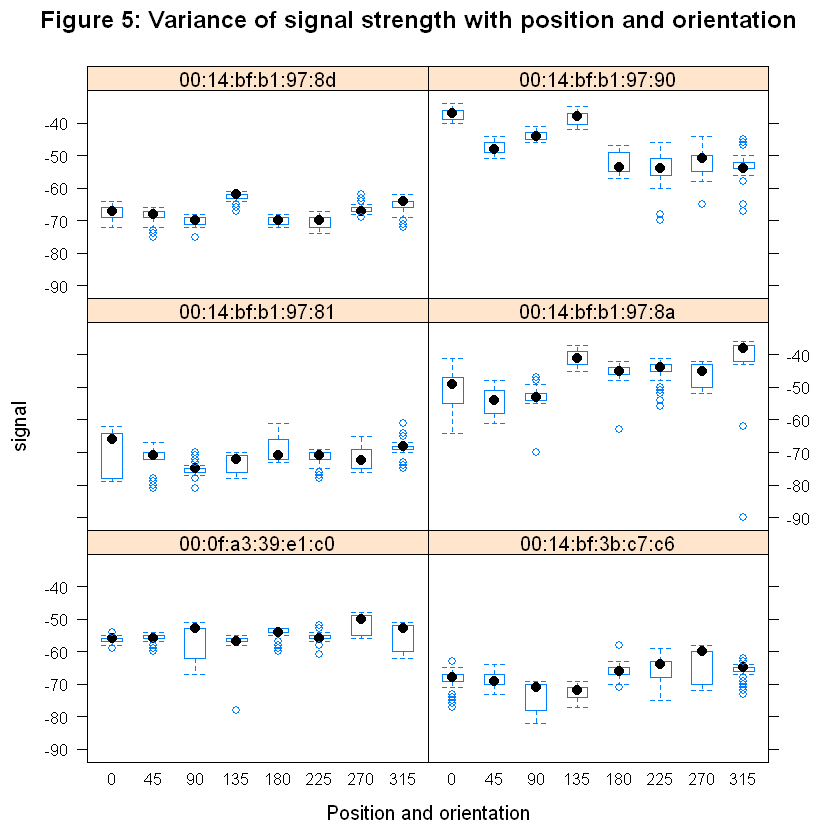

In [13]:
#pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12 
                & mac != "00:0f:a3:39:dd:cd", 
       layout = c(2,3), xlab = "Position and orientation", main = "Figure 5: Variance of signal strength with position and orientation")
par(oldPar)
dev.off()

summary(offline$signal)

null device 
          1

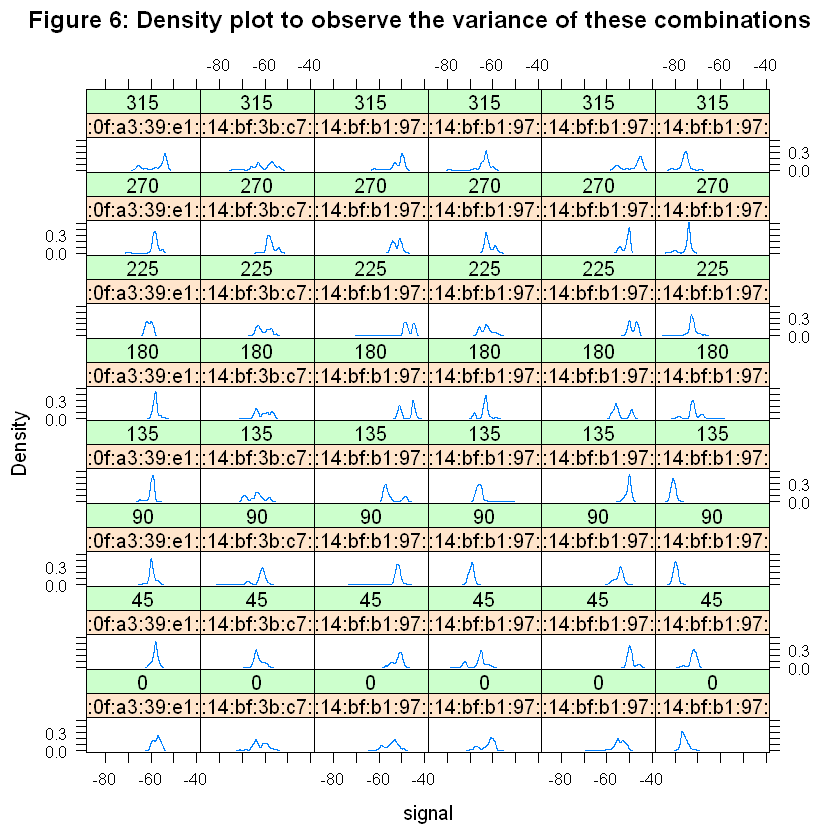

In [14]:
#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac != "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE, main = "Figure 6: Density plot to observe the variance of these combinations")

par(oldPar)
dev.off()

In [15]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)  

null device 
          1

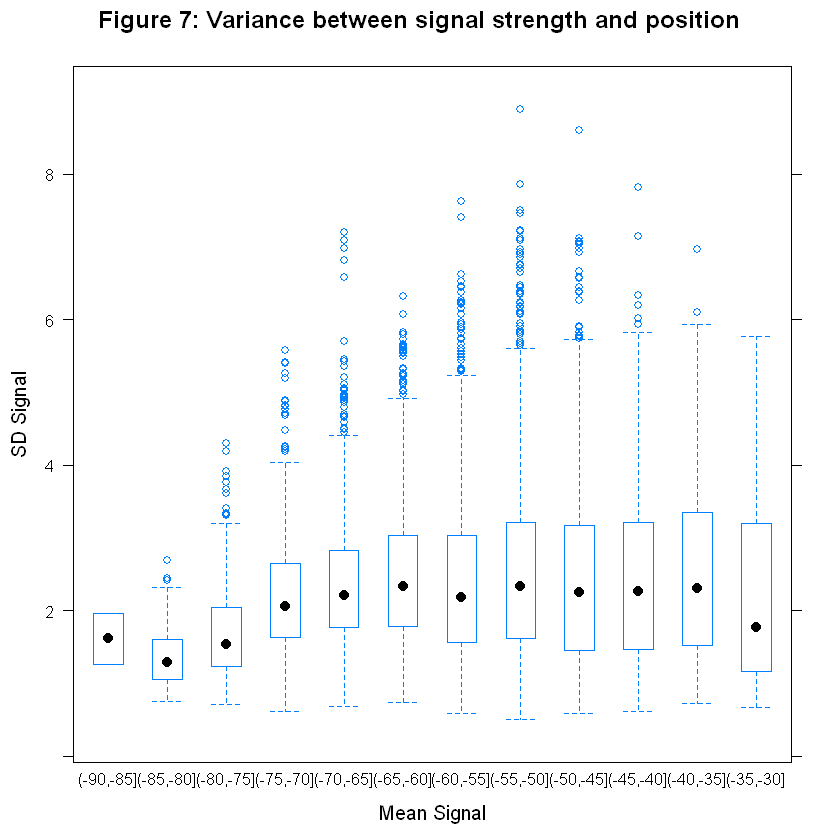

In [16]:
#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", ylab = "SD Signal", main = "Figure 7: Variance between signal strength and position")

par(oldPar)
dev.off()

null device 
          1

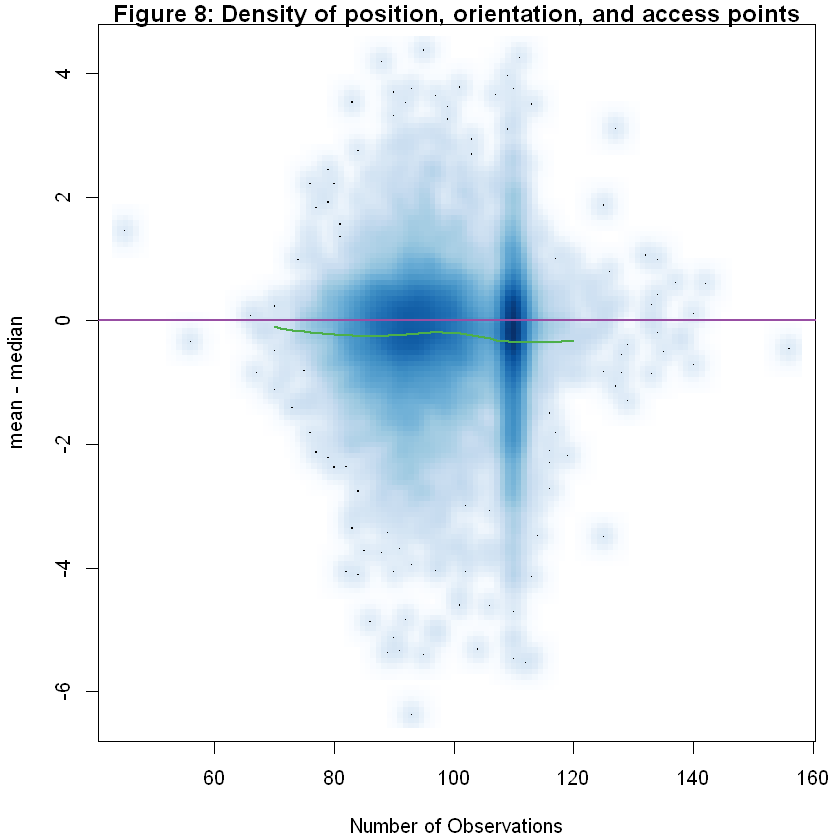

In [17]:
#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)
title("Figure 8: Density of position, orientation, and access points")

lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()
 
oneAPAngle = subset(offlineSummary, 
                    mac == subMacs[5] & angle == 0)

### Relationship Between Signal and Distance

A heatmap helps identify the actual areas of the floor plan where signals are stronger. For each MAC address, orientation, and distance combination, the summary statistic "offlineSummary" is plotted. The heatmap below shows a contour plot for two MAC addresses and two orientations (0, 135) [Figure 9]. While the MAC address has never been associated with the location of the access point, we can use the contour plot to make inferences based on the floor plan.

Now that we are able to match the MAC/access point with the floor plan, we can investigate the relationship between the position variable and the signal strength. To show this, we output a scatter plot using the distance and signal strength, along with each of the 8 developed orientations. The scatter plot seems to be similar across the combinations [Figure 10].

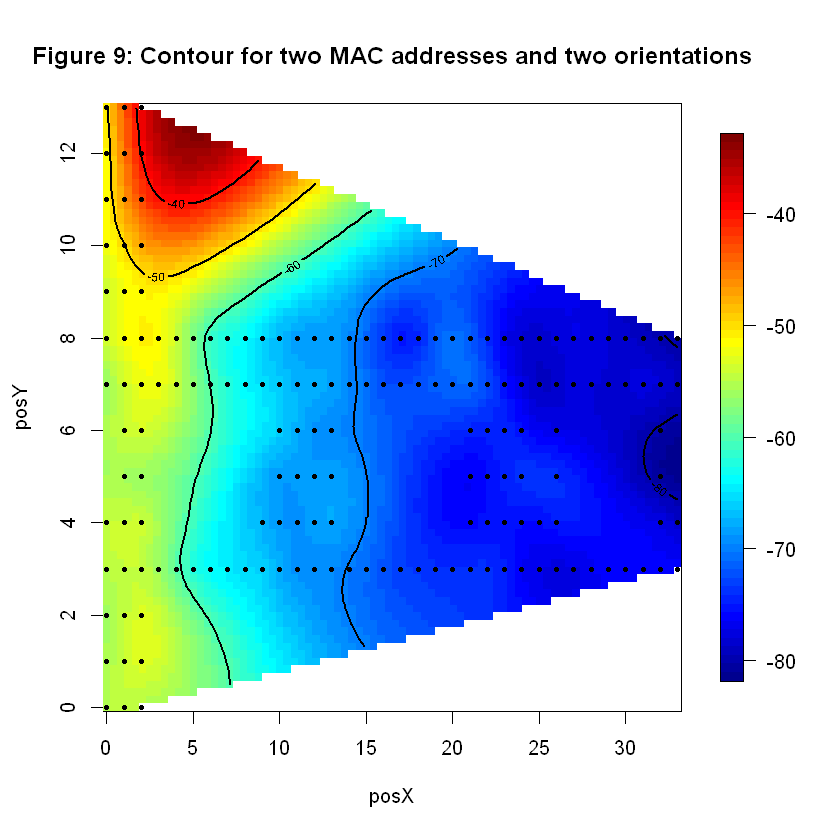

In [18]:
library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)
vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")
title("Figure 9: Contour for two MAC addresses and two orientations")

points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

In [19]:
unique(offlineSummary$mac)

[1] "00:0f:a3:39:dd:cd" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:90"

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

,x,y
00:0f:a3:39:e1:c0,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8


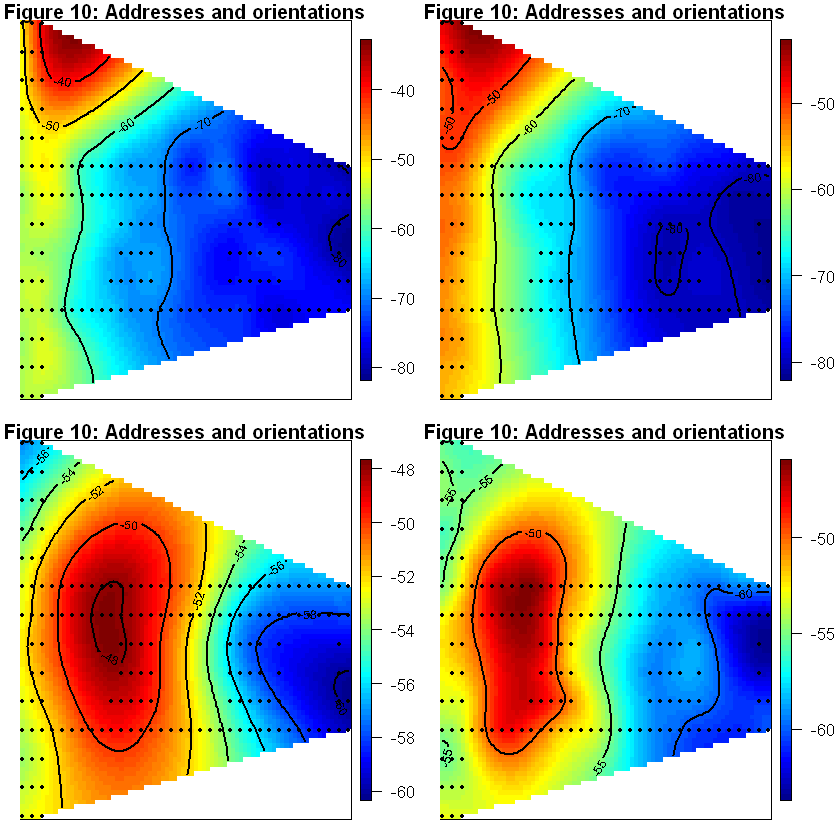

In [20]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
    title("Figure 10: Addresses and orientations")

  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary))
 
par(parCur)

offlineSummary = subset(offlineSummary, mac != subMacs[2])

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))
AP

null device 
          1

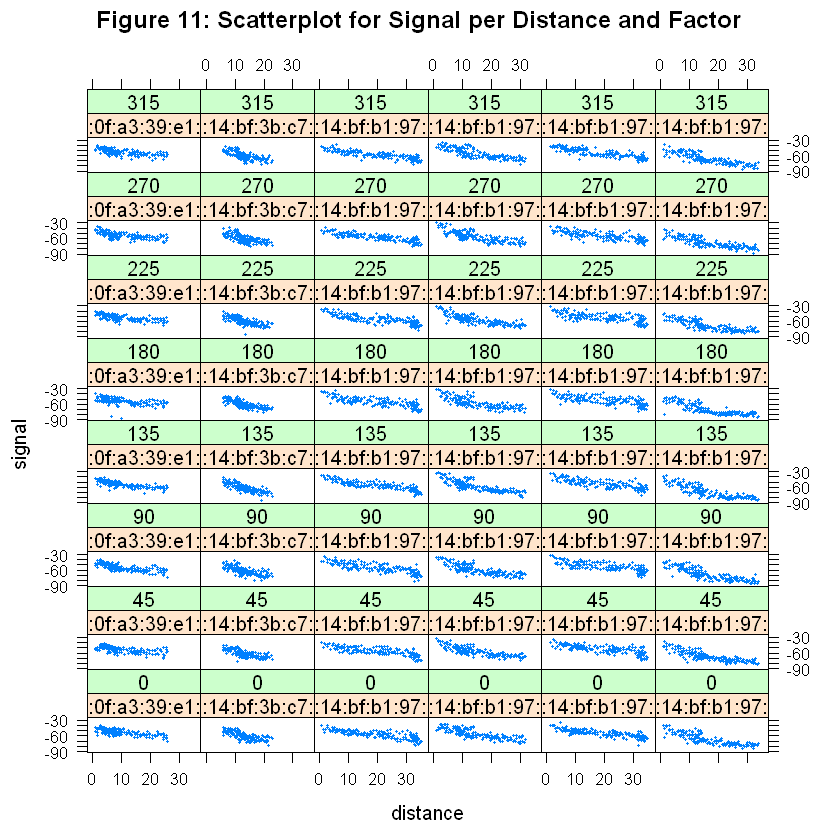

In [21]:
diffs = offlineSummary[ , c("posX", "posY")] - 
          AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance", main = "Figure 11: Scatterplot for Signal per Distance and Factor")

#pdf(file="Geo_ScatterSignalDist.pdf", width = 7, height = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))
library(lattice)
#xyplot(signal ~ dist | factor(mac) + factor(angle), 
#       data = offlineSummary, pch = 19, cex = 0.3,
#       xlab ="distance", main = "Figure 11: Scatterplot for Signal per Distance and Factor")
par(oldPar)
dev.off()

macs = unique(offlineSummary$mac)

### KNN Average Weighting
While there exist various techniques that may be used to estimate device location based on RSSI, this case study seeks to undertake a simple KNN clustering approach for test observation location determination. As such, a measure of Euclidean Distance, as depicted in the formula below, will be used to assess proximity of a test observation to the 166 potential neighbor locations:

<center>$Euclidean Distance =\sqrt{(S_1^*-S_1)^2 + ...+ (S_6^*-S_6)^2}$</center>


$S_i$ represents the strength of a signal measured between a hand-held device and an $i$-th training observation access point recorded at a specific location. Similarly, $S_1^*$ represents the signal measured between the same access point and the new point under assessment where $(x, y)$ coordinates are determined.

We create a unique location identifier column in our online data frame based on the various X-Y combinations that have now been concatenated into a new column, we have 60 unique test locations available in the online dataset. We total the number of RSSI values recorded at each location, where the following output depicts 10 randomly sampled location tallies by orientation. This sampling reveals that RSSI values were recorded at only one orientation for each location.


In [22]:
online = readData("Data/online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")
length(unique(online$posXY))

set.seed(seed = seed)
# Number of signal strengths recorded at each location

tabonlineXYA = table(online$posXY, online$angle)
#tabonlineXYA[1:6, ]
tabonlineXYA[sample(1:nrow(tabonlineXYA), 10), ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  

[1] 60

            
               0  45  90 135 180 225 270 315
  22.38-3.94   0   0   0   0   0   0   0 543
  24.7-7.7     0   0 571   0   0   0   0   0
  12.18-3.4    0   0   0   0   0   0 568   0
  21.23-5.47   0   0   0 576   0   0   0   0
  9.08-7.24  550   0   0   0   0   0   0   0
  12.55-7.38 573   0   0   0   0   0   0   0
  0-0.05       0   0   0 593   0   0   0   0
  2.49-7.6     0   0   0   0   0   0   0 593
  12.26-6.72   0   0 581   0   0   0   0   0
  0.78-10.94 586   0   0   0   0   0   0   0

We restructure the data into 6 columns of signal strengths rather than only a single signal strength column with all access points. Each access point will have its own column comprised of its respective RSSI values and used to compute distance between the 6 signal strength vectors. We provide the average signal strength at each location as summary and depict the first 6 locations. Notice 11 columns are present in our summary, including the concatenated X-Y values, X and Y values in their separate columns, orientation, angle, and the 6 access points' average RSSI values.

In [23]:
dim(onlineSummary)

names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

[1] 60 11

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:e1:c0"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

Since orientation impacts signal strength, offline data points with similar orientations are used for new location points. We select all records within a particular range of the test point's orientation and specify the number of neighboring angles to include from the offline dataset. For even numbers, this means selecting even multiples of 45 degrees on each side of a test observation's orientation angle. For odd numbers, it means selecting offline data with angles which match the new observation's rounded orientation as well as those that flank the new observation's angle. In the case where only one orientation is desired, offline data with angles matching the new observation's will be selected only. We create a data structure aggregating the RSSI values from these angles as described in the following code.

In [24]:
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

In [25]:
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

Table 1 depicts the data structure created for an angle of 130 degrees using 3 angles in total, where only the first 6 rows are shown. This, therefore, is an aggregation for angles of 90, 135, and 180 degrees. The average signal strengths are computed for the different angles by the selectTrain function and that one set of signal strengths is created for each of the offline dataset's 166 locations.

Once the angle count functions are determined, the next step is to define a function to calculate distances between new points and all offline dataset observations. The following findNN function receives 6 new signal strengths along with 6 offline signal strengths as output from the selectTrain function. Locations of offline training observations are ordered by proximity to the new test observation's RSSI values before being output by the findNN function.


#### Table 1: Data structure created for an angle of 130 degrees using 3 angles in total, where only the first 6 rows are shown

In [26]:
train130 = selectTrain(130, offlineSummary, m = 3)
train130.nrow <- nrow(train130)

head(train130)
length(train130[[1]])

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

,posXY,posX,posY,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-52.37243,-66.13039,-63.19262,-35.58063,-64.25411,-55.33780
0-1,0-1,0,1,-52.98182,-65.37177,-63.72941,-39.37649,-65.44867,-59.15328
0-10,0-10,0,10,-56.34184,-65.67238,-69.16041,-44.71545,-66.85781,-50.45502
0-11,0-11,0,11,-54.73420,-67.17593,-70.34538,-48.34689,-66.78383,-54.93054
0-12,0-12,0,12,-56.03030,-70.46493,-72.28758,-45.17264,-66.72696,-50.49886
0-13,0-13,0,13,-54.55152,-71.19211,-72.58496,-43.32784,-68.72616,-54.48160


[1] 166

Our first KNN prediction process simply averages the first k locations returned by the findNN function. This procedure, along with the findNN, selectTrain, and reshapeSS functions, is embedded in the predXY() wrapper function. We will later be comparing the results of averaging the first k locations to weighting locations based on RSSI values.

Using the predXY function, we illustrate location estimation accuracy for $k = 3$ and $k = 1$ KNN training counts. Furthermore, model fit is assessed by mapping actual and predicted locations with lines connecting the two points for each respective new observation. Figure 12 is the map for the 3-NN predictions.


In [27]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

The same is then done for the 1-NN predictions next. Note that upon comparison, errors are generally smaller for the 3-NN model than they are for 1-NN and that the largest errors tend to follow hallways rather than traverse large obstacles such as walls or other stationary barriers.

In [28]:
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "X Position", ylab = "Y Position", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

As further and more concrete assessment, we assess fits from the 3-NN and 1-NN models by comparing their Sum of Squared Error (SSE) values as follows.


null device 
          1

null device 
          1

[1] 659.4003 306.7025

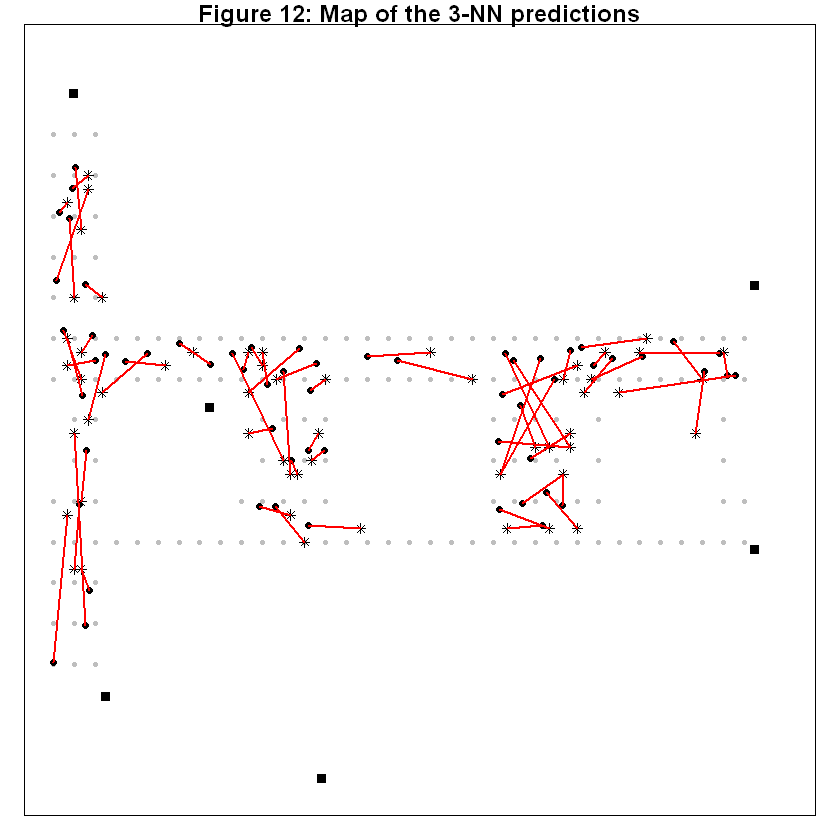

In [29]:
#pdf(file="GEO_FloorPlanK3Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
title("Figure 12: Map of the 3-NN predictions")
par(oldPar)
dev.off()

#pdf(file="GEO_FloorPlanK1Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
SSE <- sapply(list(estXYk1, estXYk3), calcError, actualXY)
SSE

Doing so reveals $k_1 SSE =$ 1659.4003 and $k_3 SSE =$ 1306.70. This correlates with the visual summary we extracted from the error maps above and confirms that 3 nearest neighbors more accurately predict location when compared to only one nearest neighbor. Even so, we still need to determine if there is another k value that would even more accurately predict device location.

In order to avoid overfitting, we must identify the optimal value of k independent of our test observations by v-fold cross validation. A $v$ value of 11 is selected since we have 166 different offline locations, allocating 15 locations to each fold. Allocations are randomly selected as follows, where 11 does not divide evenly into 166 but is acceptable in our case).

The first 6 of 15 locations from our first fold are depicted in Table 2.

Since we previously summarized our offline data into a structure containing 6 signal strength columns, one for each access point, we will do the same with our cross-validated test data. However, because it is easier to structure the test data in its complete form from offline data which is then divided into our desired folds, we now need to modify the reshapeSS function as follows.

#### Table 2: Summary of offline data into a structure containing 6 signal strength columns, one for each access point

In [30]:
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

head(onlineFold)
onlineFold.ul <- nrow(unique(onlineFold[,2:3]))

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"

,time,posX,posY,orientation,mac,signal,rawTime,angle,posXY,medSignal,avgSignal,num,sdSignal,iqrSignal,dist
73864,2006-02-11 02:47:06,0,3,0.2,00:0f:a3:39:e1:c0,-53,1.139648e+12,0,0-3,-55,-55.53636,110,2.1786170,3,8.193900
214634,2006-02-11 05:38:04,0,9,0.3,00:0f:a3:39:e1:c0,-59,1.139658e+12,0,0-9,-49,-50.99091,110,4.5443693,2,7.971198
162553,2006-02-11 04:24:26,1,9,0.5,00:0f:a3:39:e1:c0,-61,1.139653e+12,0,1-9,-54,-54.59091,110,5.0616302,9,7.038466
397974,2006-02-11 09:50:44,10,4,0.4,00:0f:a3:39:e1:c0,-54,1.139673e+12,0,10-4,-50,-49.51376,109,1.9935762,3,3.397058
384774,2006-02-11 09:33:55,13,3,359.6,00:0f:a3:39:e1:c0,-55,1.139672e+12,0,13-3,-52,-52.22727,110,0.8530473,1,6.414047
544481,2006-02-11 13:15:40,13,8,0.0,00:0f:a3:39:e1:c0,-54,1.139685e+12,0,13-8,-54,-53.34545,110,1.1287434,1,5.756735


We now proceed to summarize and format the offline data using the updated *reshapeSS()* function to produce our online cross-validation summary data structure as below.

In [31]:
#Look at all but MAC 00:0f:a3:39:dd:cd
offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

To determine the appropriate value for k based on our data, we calculate the SSE values for each value of k between 1 and 20, where the k value that produces the smallest error is selected.

In [32]:
actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

[1] 181

The SSE values produced for $k = 1$ through $k = 20$ are plotted [Figure 13].

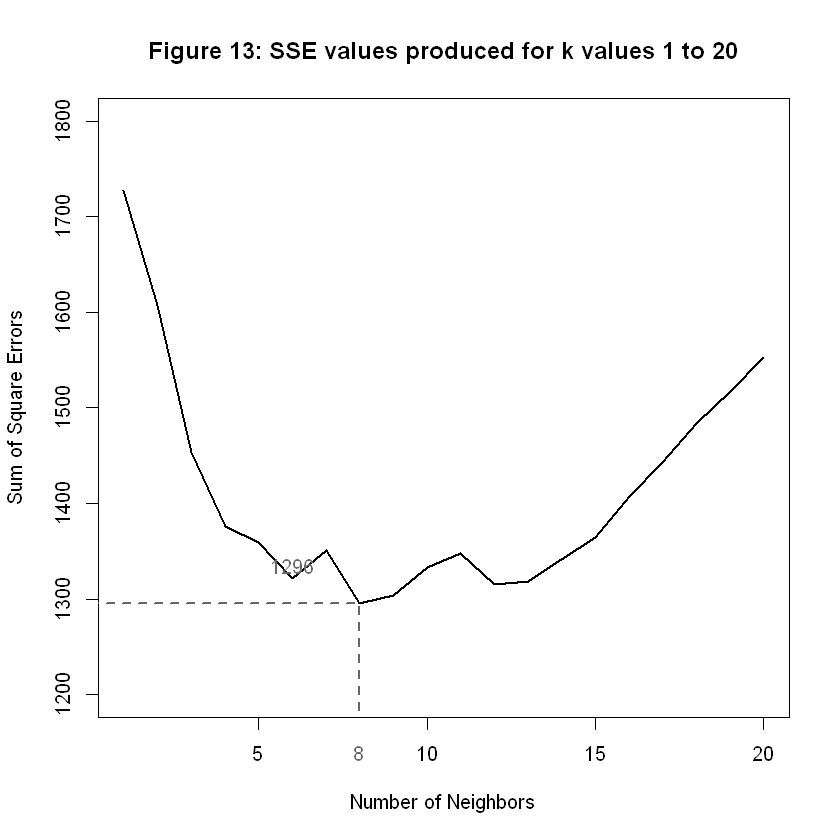

In [33]:
#pdf(file = "Geo_CVChoiceOfK.pdf", width = 10, height = 6)
#oldPar = par(mar = c(4, 3, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 1800),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")
title("Figure 13: SSE values produced for k values 1 to 20")
rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)
mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))

text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
#dev.off()

Based on our analysis, $k =$ 8 produces the least amount of error. This value differs from Nolan and Lang's $k=5$ identified in their case study walkthrough due to our random sampling during offlineSummary, onlineCVSummary, and permuteLocs function computations [1]. Had we been provided the same seed value they used during their analysis, we would have obtained the same k result. However, since the difference is due to randomness alone, our $k=$ 8 is used for the estimation to calculate final Sum of Squared Errors.


In [34]:
#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))

par(oldPar)

estXYk4 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = kMin)

SSE.k4 <- calcError(estXYk4, actualXY)
SSE.k4

[1] 269.5078

Based on these results, $k_8 SSE$ = 1269.50. This value is less than our previous reviews of $k_1 SSE$ and $k_3 SSE$ at 1659.40 and 1306.70, respectively. As expected, choosing an optimized value for k results in the most accurate model. We will use 1269.50 compare against our weighted distance KNN model.

### KNN Distance Weighting

As we estimate position by average X-Y location across k nearest points, the distance of those points may be relevant to the accuracy of the model. To test this, we apply weights to the X-Y positions of each k closest locations and take the sum of those results instead of averaging the values. With the below formula, we are able to compute weights for each k closest observations.


In [35]:
#Modify findNN to also output the distances
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(list(trainSubset[closest, 1:3 ],dists[order(dists)]))
}

$$
\begin{aligned}
\frac{1/d_i}{\sum_{i=1}^{k}1/d_i}
\end{aligned}
$$

The findNN function has been modified from the previous version to also output the distance metrics utilized in determining the closest k points. In addition, the predXY() function has been modified to compute weights with the formula above and distance outputs from the findNN output. These weights are multiplied against each k nearest observation, respectively, then summed to compute a weighted estimation by distance. These new calculations may allow locations of closer distances to be more impactful than those further away instead of equal weighting among the k points.

In [36]:
#Modify findNN to utilize distance output for estimation efforts
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  closeDist = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    fnnResult =
    findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  
    closeXY[[i]] = fnnResult[[1]]
    closeDist[[i]] = fnnResult[[2]]
  }
  
  distWeight = list(length = length(closeDist))
  
  for (i in 1:length(closeDist)){
    distW = list(length = k)

    for (j in 1:k){
      distW[j] = (1/closeDist[[i]][j])/sum(1/closeDist[[i]][1:k])
    }
     
    distWeight[[i]] =  distW
  }

  estXYDetails = list(length=length(closeXY))
  
  for(i in 1:length(closeXY)){
    estXYDetails[[i]] = as.matrix(closeXY[[i]][1:k,2:3]) * unlist(distWeight[[i]])
  }
  
  estXY = lapply(estXYDetails,
                 function(x) apply(x, 2,
                                   function(x) sum(x)))
    
  estXY = do.call("rbind", estXY)
  return(estXY)
}                                   

In [37]:
set.seed(seed = seed)
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

We perform fold tests on 1-20 k nearest neighbor estimations, where we utilize the distance weighting modifications for each estimation. Sum of Squared Errors is plotted for each k iteration in Figure 14. 


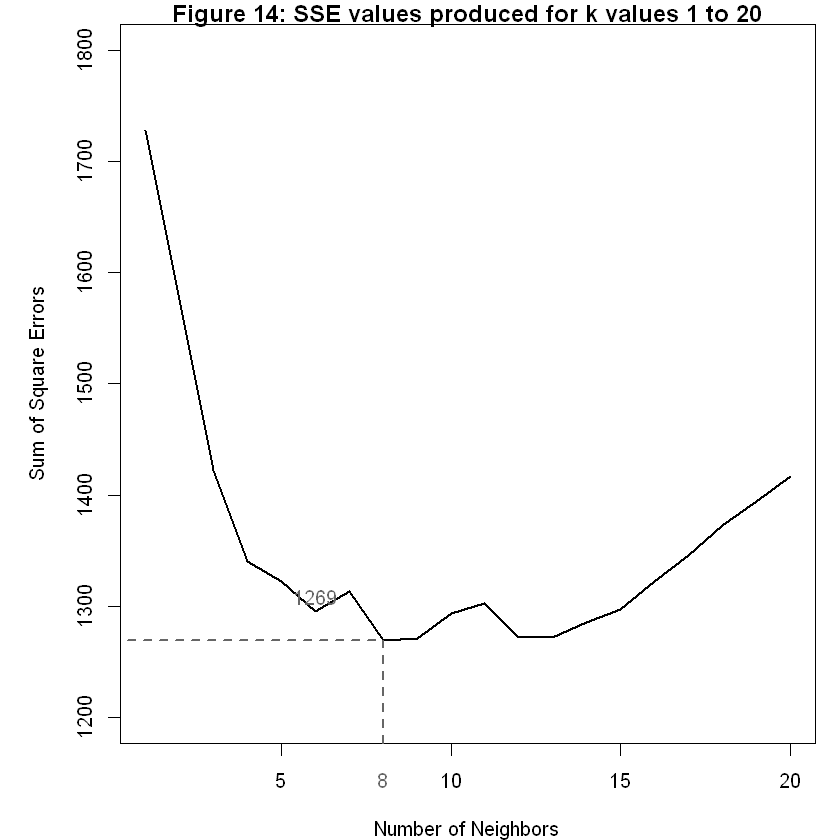

In [38]:
set.seed(seed = seed)

oldPar = par(mar = c(4, 5, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 1800),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")
title("Figure 14: SSE values produced for k values 1 to 20")

rmseMin = min(err)
kMin2 = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin2, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin2, x1 = kMin2, y0 = 900,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

mtext(kMin2, side = 1, line = 1, at = kMin2, col = grey(0.4))
text(x = kMin2 - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
par(oldPar)

Plotting SSE values for 20 k test iterations, we see that $kmin =$ 8 produces optimal results at a SSE value of 1296.71

In [39]:
set.seed(seed = seed)

estXYk8 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = kMin2)

calcError(estXYk8, actualXY)

[1] 267.4118

With our optimal k value selected for number of nearest points, we compute predictions utilizing the weighted distance estimation method, storing the SSE values for comparison to the average location methods.

### KNN Comparison

With optimal prediction method inputs defined for both average location estimation and weighted distance estimation, we compare estimations both visually and through SSE values. Average Location Estimates vs Actual [Figure 15] and Weighted Distance Estimates vs Actual [Figure 16] plots help to describe how accurate the estimations were. Errors in both models seem to struggle the most in narrow hallways. This large error makes sense, given the fewer observations available for $k$ matches. Overall, differences in these outputs show very similar results with some errors being largely minimized by the weighted distance strategy and others slightly increased. Although these measures appear fairly close to one another, it does appear as though the weighted distance methodology has a slight advantage with a SSE of 1296.71 than 1269.50 for average.

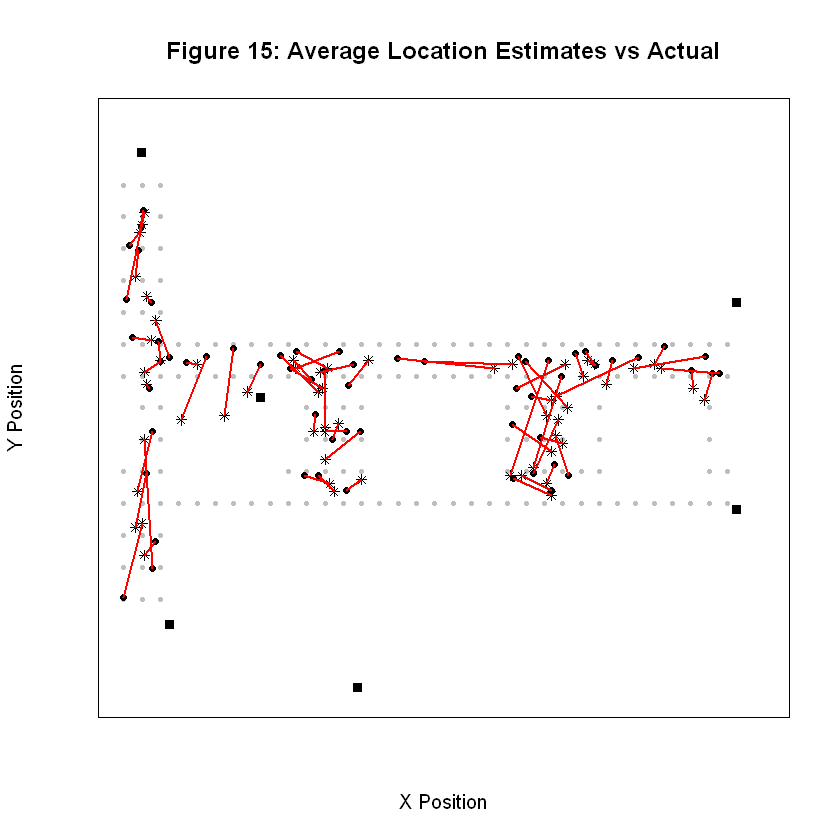

In [40]:
oldPar = par(mar = c(1, 1, 1, 1))
par(oldPar)
floorErrorMap(estXYk4, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
title('Figure 15: Average Location Estimates vs Actual')

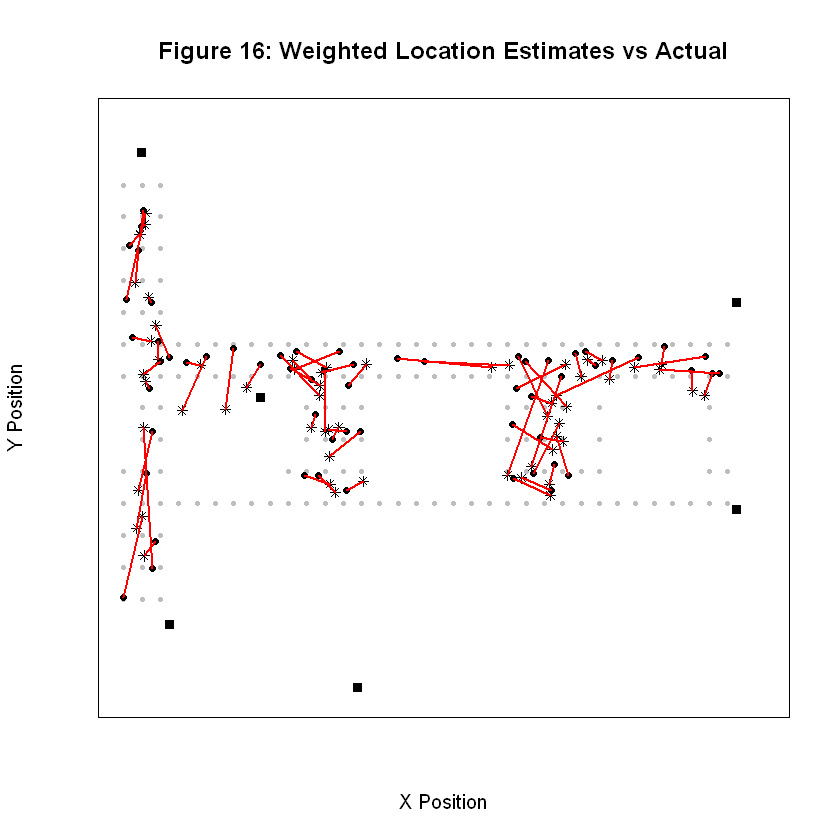

In [41]:
oldPar = par(mar = c(1, 1, 1, 1))
par(oldPar)
floorErrorMap(estXYk8, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
title('Figure 16: Weighted Location Estimates vs Actual')

## Conclusion

By comparing SSE values for each method, $k_{8WeightedDistance}SSE =$ 1296.71 through weighted distance estimation is slightly better than our average distance estimation of $k_{8AverageLocation}SSE$ at 1269.50. This aligns with our observations made from the visual error maps; weighted distance estimation provides more accurate results overall in the model [Figure 15 and 16]. These weighted distances allow those k observations that are heavily skewed, with few observations of close distance and large number of observations of large distance, to be appropriately computed without biased input from the further distance points. 

As with outdoor GPS location services, RTLS ecosystems are becoming more ubiquitous. As RTLS usage increases, the need for accurate and innovative indoor location prediction models increases as well. After wrangling and structuring both offline training data and online training and test data, exploratory analysis lead into kNN models for both averaged X-Y coordinates and weighted coordinates as a function of distance in the form of RSSI. While both models provided accurate estimates of device location, our model with weighted coordinates had the smallest sum of squares error for location estimation.

## References
1. D. Lang and D. Nolan, Data Science in R: A Case Studies Approach to Computation Reasoning and Problem Solving. New York, New York: CRC Press.

2. R. Slater. "six mac," 2DS SMU, [R Notebook]. 2018. Class Attachment Download. [Accessed: 18-June-2018].
